# Product quality check

### Câu hỏi: 

### Giới thiệu thành viên

1. Nguyễn Đức Trực
2. 
3.


### Ý nghĩa của việc trả lời câu hỏi


## Import

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from matplotlib.gridspec import GridSpec
set_config(display='diagram') # Để trực quan hóa pipeline

# You can also import other things ...
# YOUR CODE HERE (OPTION)

In [2]:
import sklearn
sklearn.__version__

'1.0.1'

## Phần 1: Khám phá dữ liệu 

In [3]:
data_df = pd.read_csv('practice_data.csv', index_col=0).reset_index(drop=True)
data_df.head(5)

,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,factory_inspection_fail_rate_120,...,factory_product_measurement_major_defect_rate_60,factory_product_measurement_major_defect_rate_90,factory_product_measurement_major_defect_rate_120,factory_product_measurement_major_defect_rate_150,factory_product_measurement_minor_defect_rate_30,factory_product_measurement_minor_defect_rate_60,factory_product_measurement_minor_defect_rate_90,factory_product_measurement_minor_defect_rate_120,factory_product_measurement_minor_defect_rate_150,label
0,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.0,0.032258,0.028571,0.027778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,5,1.0,0.0,0.200000,0.035714,0.020408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,c0bffcf0318c483b2dbb1c56bed6efa58f9717bd,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,8,NaN,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,c96f3f1c47dca83af551893a28c3409cb4afd31d,Guatemala,e06d28d1365467625ebfa999328501705a3398bb,2,12,1.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,63ffdba896c8bb150eca939d1eb7e3bd4e732ed4,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,2,1.0,0.0,0.000000,0.000000,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [4]:
data_df.shape

(13293, 155)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa thông tin của một mã hàng, và có vẻ không có vấn đề các dòng có ý nghĩa khác nhau.

### Dữ liệu có các dòng bị lặp không?

In [6]:
data_df.index.duplicated().sum()

0

### Mỗi cột có ý nghĩa gì?

## Khám phá dữ liệu (để biết cách tách các tập)


In [7]:
# Cột output hiện có kiểu dữ liệu gì?
data_df['label'].dtype

dtype('int64')

In [8]:
# Cột output có giá trị thiếu không?
data_df['label'].isna().sum()

0

In [9]:
# Tỉ lệ các lớp trong cột output?
data_df['label'].value_counts(normalize=True) * 100

0    95.095163
1     4.904837
Name: label, dtype: float64

OK, như vậy dữ liệu mất cân bằng khá nặng

## Phần 2: Tiền xử lý (tách các tập)

### Bây giờ ta sẽ thực hiện bước tiền xử lý là tách tập train và tập test ra theo tỉ lệ: 80%:20%.

In [38]:
# Tách X và y
y_sr = data_df["label"] # sr là viết tắt của series
X_df = data_df.drop("label", axis=1)

In [39]:
# train /  test
X_df, test_df, y_sr, test_sr = train_test_split(X_df, y_sr, test_size=0.2, 
                                                              stratify=y_sr, random_state=15)

In [40]:
X_df.shape,  test_df.shape

((10634, 154), (2659, 154))

In [41]:
y_sr.shape, test_sr.shape

((10634,), (2659,))

## Phần 3: Khám phá dữ liệu (tập huấn luyện) + Visualization

### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [14]:
X_df.dtypes

hashed_factory_id                                     object
country                                               object
hashed_type_of_inspection                             object
style_number                                          object
item_number                                           object
                                                      ...   
factory_product_measurement_minor_defect_rate_30     float64
factory_product_measurement_minor_defect_rate_60     float64
factory_product_measurement_minor_defect_rate_90     float64
factory_product_measurement_minor_defect_rate_120    float64
factory_product_measurement_minor_defect_rate_150    float64
Length: 154, dtype: object

In [112]:
x = X_df.dtypes[X_df.dtypes == object]
x, x.shape

(hashed_factory_id            object
 country                      object
 hashed_type_of_inspection    object
 style_number                 object
 item_number                  object
 brand_number                 object
 hashed_product_line          object
 hashed_product_category      object
 hashed_product_id            object
 dtype: object,
 (9,))

In [113]:
x = X_df.dtypes[X_df.dtypes == np.number]
x, x.shape

(factory_inspection_fail_rate_30                      float64
 factory_inspection_fail_rate_60                      float64
 factory_inspection_fail_rate_90                      float64
 factory_inspection_fail_rate_120                     float64
 factory_inspection_fail_rate_150                     float64
                                                       ...   
 factory_product_measurement_minor_defect_rate_30     float64
 factory_product_measurement_minor_defect_rate_60     float64
 factory_product_measurement_minor_defect_rate_90     float64
 factory_product_measurement_minor_defect_rate_120    float64
 factory_product_measurement_minor_defect_rate_150    float64
 Length: 145, dtype: object,
 (145,))

 * Nhận xét về tập dữ liệu
   - Dữ liệu có 154 thuộc tính, gồm 9 cột object và 145 cột float
   - Thuộc tính có vẻ kiểu dữ liệu phù hợp.

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

Trong `X_df`, có 145/154 cột có dtype không phải là object:

In [18]:
X_df.dtypes[X_df.dtypes != object]

factory_inspection_fail_rate_30                      float64
factory_inspection_fail_rate_60                      float64
factory_inspection_fail_rate_90                      float64
factory_inspection_fail_rate_120                     float64
factory_inspection_fail_rate_150                     float64
                                                      ...   
factory_product_measurement_minor_defect_rate_30     float64
factory_product_measurement_minor_defect_rate_60     float64
factory_product_measurement_minor_defect_rate_90     float64
factory_product_measurement_minor_defect_rate_120    float64
factory_product_measurement_minor_defect_rate_150    float64
Length: 145, dtype: object

In [21]:
cols_number = list(X_df.dtypes[X_df.dtypes != object].index)
df = X_df[cols_number]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df = df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])
df

,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,factory_inspection_fail_rate_120,factory_inspection_fail_rate_150,product_available_quantity,product_ppm_1,product_ppm_2,product_ppm_3,product_ppm_4,...,factory_product_measurement_major_defect_rate_30,factory_product_measurement_major_defect_rate_60,factory_product_measurement_major_defect_rate_90,factory_product_measurement_major_defect_rate_120,factory_product_measurement_major_defect_rate_150,factory_product_measurement_minor_defect_rate_30,factory_product_measurement_minor_defect_rate_60,factory_product_measurement_minor_defect_rate_90,factory_product_measurement_minor_defect_rate_120,factory_product_measurement_minor_defect_rate_150
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,5.0,0.000000,0.00,0.066667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lower_quartile,0.0,0.0,0.0,0.0,0.0,1758.5,0.000000,0.00,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median,0.0,0.0,0.0,0.0,0.0,6390.0,0.000000,0.00,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
upper_quartile,0.0,0.0,0.0,0.0,0.0,18502.5,0.000000,0.00,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1220064.0,0.466667,0.75,1.000000,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Kiểm tra xem các cột nummeric có bị thiếu giá trị

In [28]:
np.any(df.loc['missing_ratio'] > 0)

False

### Với mỗi cột input có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [47]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
obj_cols = list(X_df.dtypes[X_df.dtypes == object].index)
df = X_df[obj_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df= df.agg([missing_ratio, num_values, value_ratios])
df

,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,hashed_product_line,hashed_product_category,hashed_product_id
missing_ratio,0.0,0.5,0.5,0.5,0.4,0.4,0.4,0.5,0.0
num_values,315,77,71,75,180,52,55,95,125
value_ratios,"{'8e0114f5d7c26b37cec7f58a197a93bbc49e14a6': 2.1, 'eb71b01d780141d63504b372bee1ee42f7858358': 2.0, 'e483609c921a0ad7710a772b2e3bd13f401afb3d': 1.9, '4d701e1799c258c07060770fed4563167c3d2d93': 1.7,...","{'Vietnam': 42.2, 'China': 17.8, 'Indonesia': 12.2, 'Bangladesh': 7.7, 'Nicaragua': 4.5, 'Guatemala': 3.6, 'Pakistan': 3.2, 'India': 2.7, 'Cambodia': 2.7, 'Jordan': 1.1, 'Haiti': 1.0, 'Thailand': ...","{'e06d28d1365467625ebfa999328501705a3398bb': 70.0, '7ba31299766426922dbeb7c96b247068252ea5eb': 15.7, '4a31b54c7b1ada762e54a711dc598073de477352': 9.3, '28b2f8071a0bee27a173b310507c0946868183cc': 3....","{'1': 53.9, '2': 24.3, '3': 10.3, '4': 4.9, '5': 2.7, '6': 1.6, '7': 0.7, '8': 0.4, '10': 0.3, '9': 0.2, '12': 0.1, '15': 0.0, '11': 0.0, '18': 0.0, '13': 0.0, 'number_16738': 0.0, 'number_17052':...","{'10': 7.9, '6': 7.6, '12': 7.4, '18': 6.4, '24': 5.5, '20': 4.9, '5': 4.6, '30': 4.4, '15': 3.5, '36': 3.0, '40': 2.5, '11': 2.4, '8': 1.9, '48': 1.6, '4': 1.6, '9': 1.6, '25': 1.5, '42': 1.5, '1...","{'1.0': 94.6, '2.0': 4.5, '3.0': 0.5, '4.0': 0.0, 'number_15020': 0.0, 'number_8329': 0.0, 'number_13830': 0.0, 'number_8218': 0.0, 'number_2444': 0.0, 'number_9802': 0.0, 'number_2440': 0.0, 'num...","{'a8a2b30f8dba82d690db42ce743475f11be31030': 99.2, '7ec24305aabd039523e863b97fc436f600b30b42': 0.2, 'be2793cdd2af9b687e24da064353ecd4681052d2': 0.0, 'f0483f255e0ce2c93d5dfa593f2161b266474869': 0.0...","{'6a812c559943cb2c29da6c739b132c3d4a8905f1': 25.0, '3e320c3e3556eccdfbd52ef5c5ef5e8c87571101': 15.7, 'c67af124d1806581c4ad29dc616db381f5d8e694': 6.7, '174f4586e4ccef9bc5137f310b761274932be8df': 6....","{'28f9ef723778c6d377fc75ac131ed352e708eb21': 12.4, 'e7bad74dd28e94f1daf841c9e59086263524c38d': 6.5, '23748c0065b54b1512899bef390a9a1afff01150': 6.0, '12cd99beee59d3f006dcde774fc030dcab312e74': 5.3..."


- Kiểm tra xem các cột *object* có bị thiếu giá trị

In [35]:
df.loc['missing_ratio'] 

hashed_factory_id            0.0
country                      0.5
hashed_type_of_inspection    0.5
style_number                 0.6
item_number                  0.4
brand_number                 0.5
hashed_product_line          0.4
hashed_product_category      0.5
hashed_product_id            0.0
Name: missing_ratio, dtype: object

- Đa số cột object có thiếu giá trị, tỷ lệ không nhiều lắm.

## Visualization các cột object

<AxesSubplot:>

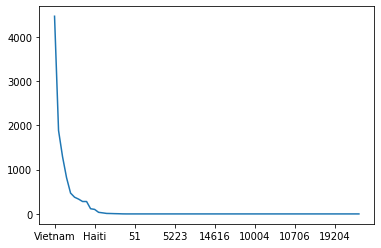

In [116]:
X_df['country'].value_counts().plot()

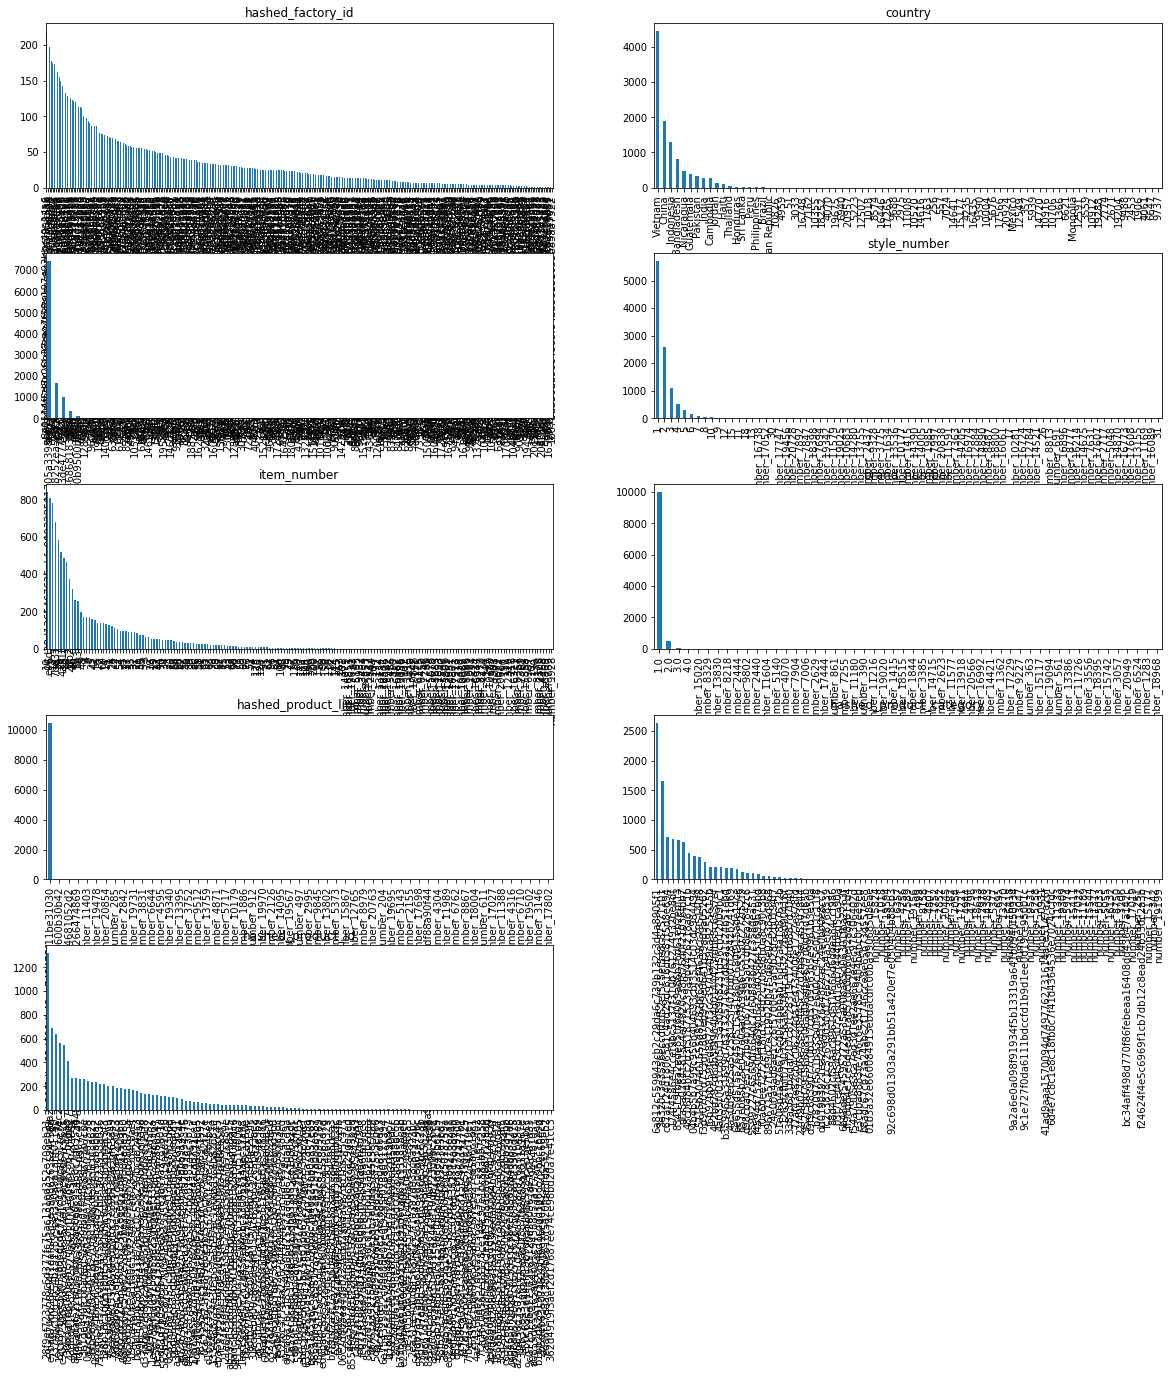

In [120]:
gs = GridSpec(5, 2)
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.2, hspace = 0.4)
for index, cat_col in enumerate(obj_cols):
    ax = plt.subplot(gs[index])
    X_df[cat_col].value_counts().plot.bar()
    ax.set_title(cat_col)

## Phần 4: Tiền xử lý (tập huấn luyện)

### Ta tiến hành tiền xử lý như sau:


- Với cột 'country' ta lấy top 17 giá trị xuất hiện nhiều nhất và các giá trị còn lại điền Others
-
-


In [89]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_titles=1, col = ''):
        self.num_top_titles = num_top_titles
        self.col = col
    def fit(self, X_df, y=None):
        self.title_counts_ = X_df[self.col].value_counts()
        titles = list(self.title_counts_.index)
        self.top_titles_ = titles[:max(1, min(self.num_top_titles, len(titles)))]
        return self
    def transform(self, X_df, y=None):
        title_col = X_df[self.col]
        fewer_cols_train_X_df = X_df.copy()
        fewer_cols_train_X_df[self.col] =title_col.apply(lambda x: x if x in col_adderdropper.top_titles_ else 'Others')
        return fewer_cols_train_X_df

In [114]:
col_adderdropper = ColAdderDropper(num_top_titles= 17, col = 'country')
col_adderdropper.fit(X_df)
col_adderdropper.transform(X_df)['country'].value_counts()

Vietnam        4461
China          1882
Indonesia      1291
Bangladesh      818
Nicaragua       471
Guatemala       378
Pakistan        335
Cambodia        281
India           281
Others          119
Jordan          118
Haiti           103
Thailand         37
Honduras         25
Sri Lanka        12
Peru             10
Philippines       7
Brazil            5
Name: country, dtype: int64

### Các bước tiền xử lý tiếp theo như sau:

 - Với các cột dạng số, ta sẽ điền giá trị thiếu bằng giá trị mean của cột.
 - Với các cột không phải dạng số ta sẽ điền giá trị thiếu bằng giá trị mode (giá trị xuất hiện nhiều nhất) của cột. Sau đó, ta sẽ chuyển sang dạng số bằng phương pháp mã hóa one-hot (vì các cột này đều có dạng nominal).
 - Cuối cùng, khi tất cả các cột đã được điền giá trị thiếu và đã có dạng số, ta sẽ tiến hành chuẩn hóa.

In [48]:
unorder_cate_cols = obj_cols

#unorder_cate_cols = []

mode_ordercols = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
mode_unordercols = make_pipeline(mode_ordercols, OneHotEncoder(handle_unknown='ignore'))

col_transform = ColumnTransformer([('unorder_cate_cols', mode_unordercols, unorder_cate_cols)],remainder='passthrough')
scale = StandardScaler(with_mean=False)
preprocess_pipeline = make_pipeline(col_transform, scale)

## Phần 5: Tiền xử lý + mô hình hóa

### Tìm mô hình tốt nhất

- Sử dụng độ do F1-weighted cho mô hình phân loại dữ liệu mất cân bằng.

## 1. Mô hình LightGBM

In [103]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier

model = lgb.LGBMClassifier(class_weight={0: 1.5, 1: 5.5}, random_state = 15)  #Phạt mô hình ở class_weight
tuned_parameters  = {'num_leaves': [29,30,31], 
                    'n_estimators': [120,150,180]}
param_grid = GridSearchCV(model, tuned_parameters, cv =5, scoring = 'f1_weighted')
clf = make_pipeline(col_adderdropper, preprocess_pipeline, param_grid)

In [104]:
clf.fit(X_df, y_sr)
param_grid.best_score_

0.9290779324549767

In [79]:
param_grid.best_estimator_

LGBMClassifier(class_weight={0: 1.5, 1: 5.5}, n_estimators=120, num_leaves=30,
               random_state=15)

## 2. Mô hình  DecisionTreeClassifier

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [109]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier

model_2 = DecisionTreeClassifier(class_weight={0: 1.5, 1: 5.5}, random_state = 15)  #Phạt mô hình ở class_weight
tuned_parameters_2 ={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10],
                         'min_samples_leaf': [10, 20, 50]},
param_grid_2 = GridSearchCV(model_2, tuned_parameters_2, cv =5, scoring = 'f1_weighted')
clf_2 = make_pipeline(col_adderdropper, preprocess_pipeline, param_grid_2)

In [110]:
clf_2.fit(X_df, y_sr)
param_grid.best_score_

0.9290779324549767

In [111]:
param_grid_2.best_estimator_

DecisionTreeClassifier(class_weight={0: 1.5, 1: 5.5}, max_depth=5,
                       min_samples_leaf=50, random_state=15)

#### Độ chính xác trên tập test sau khi chọn model tốt nhất

In [105]:
clf = make_pipeline(preprocess_pipeline, param_grid.best_estimator_)
clf.fit(X_df, y_sr)
print(f1_score(test_sr, clf.predict(test_df), average='weighted'))

0.9325313633141421


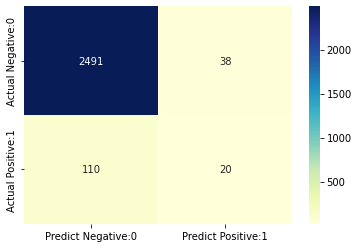

In [81]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_sr, clf.predict(test_df))
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])

_ = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Phần 6: Nhìn lại quá trình làm đồ án
* Khó khăn
* Những điều hữu ích học được

* Những dự định nếu có thời gian thêm


## Phần 7: Tài liệu tham khảo

- Google.com